# AutoGluon Fit Backend Tutorial (Distributed)

## Prerequisite
Please read **AutoGluon Task Scheduler Tutorial** first, if not yet.

## Distributed Scheduler Tutorial

<img src="img/distributed_resource_manager.png" alt="Distributed Resource Manager" style="width: 600px;"/>

**Create Distributed Scheduler** for 8 servers, we launch the program from master node and provide the ip addresses for other nodes. Each node has 1 GPU (`p3.xlarge`)

In [1]:
import autogluon as ag
from autogluon import autogluon_method

# Make sure the master node can access the other nodes through ssh.
# Make sure AutoGluon Package is installed on the machines.
extra_node_ips = ['172.31.1.97',
                  '172.31.3.224',
                  '172.31.6.120',
                  '172.31.1.216',
                  '172.31.14.8',
                  '172.31.14.237']

# Create a distributed scheduler. If no ipaddresses are provided, 
# scheduler will only use the local resources
scheduler = ag.distributed.DistributedTaskScheduler()#extra_node_ips)

# Add additional node after intialize or at anytime.
scheduler.add_remote('172.31.3.95')

/home/ubuntu/anaconda3/lib/python3.7/site-packages/paramiko/kex_ecdh_nist.py:39: CryptographyDeprecationWarning: encode_point has been deprecated on EllipticCurvePublicNumbers and will be removed in a future version. Please use EllipticCurvePublicKey.public_bytes to obtain both compressed and uncompressed point encoding.
  m.add_string(self.Q_C.public_numbers().encode_point())
/home/ubuntu/anaconda3/lib/python3.7/site-packages/paramiko/kex_ecdh_nist.py:96: CryptographyDeprecationWarning: Support for unsafe construction of public numbers from encoded data will be removed in a future version. Please use EllipticCurvePublicKey.from_encoded_point
  self.curve, Q_S_bytes
/home/ubuntu/anaconda3/lib/python3.7/site-packages/paramiko/kex_ecdh_nist.py:111: CryptographyDeprecationWarning: encode_point has been deprecated on EllipticCurvePublicNumbers and will be removed in a future version. Please use EllipticCurvePublicKey.public_bytes to obtain both compressed and uncompressed point encoding.
 

[ scheduler 172.31.3.95:8782 ] : /home/ubuntu/anaconda3/bin/python -m distributed.cli.dask_scheduler --port 8782
[ worker 172.31.3.95 ] : /home/ubuntu/anaconda3/bin/python -m distributed.cli.dask_worker 172.31.3.95:8782 --no-nanny --host 172.31.3.95
[ scheduler 172.31.3.95:8782 ] : distributed.scheduler - INFO - -----------------------------------------------
[ scheduler 172.31.3.95:8782 ] : distributed.scheduler - INFO - Clear task state
[ scheduler 172.31.3.95:8782 ] : distributed.scheduler - INFO -   Scheduler at:    tcp://172.31.3.95:8782
[ scheduler 172.31.3.95:8782 ] : distributed.scheduler - INFO -       bokeh at:                     :8787
[ scheduler 172.31.3.95:8782 ] : distributed.scheduler - INFO - Local Directory:    /tmp/scheduler-iq1_ldve
[ scheduler 172.31.3.95:8782 ] : distributed.scheduler - INFO - -----------------------------------------------
[ scheduler 172.31.3.95:8782 ] : distributed.scheduler - INFO - Register tcp://172.31.3.95:42100
[ scheduler 172.31.3.95:8782

In [2]:
print(scheduler)

DistributedTaskScheduler(
DistributedResourceManager{
(Remote: LocalNode REMOTE_ID: 0, 
	172.31.8.238:8781, Resource: NodeResourceManager(8 CPUs, 1 GPUs))
(Remote: Remote REMOTE_ID: 1, 
	<Remote: scheduler='tcp://172.31.3.95:8782' processes=1 cores=8>, Resource: NodeResourceManager(8 CPUs, 1 GPUs))
})



**Construct a fake training function**

In [3]:
import time
import socket
from autogluon.resource import DistributedResource

@autogluon_method
def train_fn(args):
    print('task_id: {}, lr: {}'.format(args.task_id, args.lr))
    # wait for 1 sec
    time.sleep(1.0)

**Launch 16 Tasks**

In [4]:
import argparse
import numpy as np
from autogluon.scheduler import Task

args = argparse.ArgumentParser()
config = {'lr': ag.searcher.sample_from(
            lambda: np.power(10.0, np.random.uniform(-4, -1)))}

for i in range(16):
    resource = DistributedResource(num_cpus=2, num_gpus=1)
    task = Task(train_fn, {'args': args, 'config': config}, resource)
    scheduler.add_task(task)
    
scheduler.join_tasks()

task_id: 0, lr: 0.001782649715138694
[ worker 172.31.3.95 ] : task_id: 1, lr: 0.001782649715138694
task_id: 2, lr: 0.00203228544324115
[ worker 172.31.3.95 ] : task_id: 3, lr: 0.00203228544324115
task_id: 4, lr: 0.0044915238251379995
[ worker 172.31.3.95 ] : task_id: 5, lr: 0.0044915238251379995
task_id: 6, lr: 0.07963234721775593
[ worker 172.31.3.95 ] : task_id: 7, lr: 0.07963234721775593
task_id: 8, lr: 0.00046342505832948756
[ worker 172.31.3.95 ] : task_id: 9, lr: 0.00046342505832948756
task_id: 10, lr: 0.04770681841935448
task_id: 12, lr: 0.00016940447095242734
[ worker 172.31.3.95 ] : task_id: 11, lr: 0.04770681841935448
task_id: 14, lr: 0.04171461199412462
[ worker 172.31.3.95 ] : task_id: 13, lr: 0.00016940447095242734
[ worker 172.31.3.95 ] : task_id: 15, lr: 0.04171461199412462


In [5]:
@autogluon_method
def train_fn(args, reporter):
    for e in range(10):
        # forward, backward, optimizer step and evaluation metric
        # generate fake top1_accuracy
        top1_accuracy = 1 - np.power(1.8, -np.random.uniform(e, 2*e))
        reporter(epoch=e, accuracy=top1_accuracy)

In [6]:
import argparse
import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH

args = argparse.ArgumentParser()

cs = CS.ConfigurationSpace()
lr = CSH.UniformFloatHyperparameter('lr', lower=1e-4, upper=1e-1, log=True)
cs.add_hyperparameter(lr)

searcher = ag.searcher.RandomSampling(cs)

In [7]:
myscheduler = ag.distributed.DistributedFIFOScheduler(train_fn, args,
                                                      resource={'num_cpus': 2, 'num_gpus': 1}, 
                                                      searcher=searcher, num_trials=20,
                                                      reward_attr='accuracy',
                                                      time_attr='epoch')

In [8]:
myscheduler.run()

top1_accuracy: 0.0
top1_accuracy: 0.5863693518624175
top1_accuracy: 0.8276781260559752
top1_accuracy: 0.8645766704225891
top1_accuracy: 0.931797268489984
top1_accuracy: 0.9721594781664106
top1_accuracy: 0.9932800942870174
top1_accuracy: 0.994114835361443
top1_accuracy: 0.9938883986616925
top1_accuracy: 0.9991894482946119
top1_accuracy: 0.0
top1_accuracy: 0.4511797936000047
top1_accuracy: 0.8534624098320646
top1_accuracy: 0.9542137204119352
top1_accuracy: 0.9704954194962195
top1_accuracy: 0.9726652277177581
top1_accuracy: 0.9853780616843826
top1_accuracy: 0.9992853483454827
top1_accuracy: 0.9959030073572825
top1_accuracy: 0.9968406995955217
top1_accuracy: 0.0
top1_accuracy: 0.4507677868584513
top1_accuracy: 0.8209554596685729
top1_accuracy: 0.9522453810238602
top1_accuracy: 0.9645313815542007
top1_accuracy: 0.9872926053611709
top1_accuracy: 0.9718946222994904
top1_accuracy: 0.9978011051280421
top1_accuracy: 0.9998917367123028
top1_accuracy: 0.9999440389170993
[ scheduler 172.31.3.95:878

top1_accuracy: 0.9941629739722434


top1_accuracy: 0.9971936597737974
top1_accuracy: 0.99971957634648
top1_accuracy: 0.997289532679794
top1_accuracy: 0.9956597381250288
[ worker 172.31.3.95 ] : top1_accuracy: 0.9984705217134404
[ worker 172.31.3.95 ] : top1_accuracy: 0.9924482700464
[ worker 172.31.3.95 ] : top1_accuracy: 0.9992405701254338
[ worker 172.31.3.95 ] : top1_accuracy: 0.0
[ worker 172.31.3.95 ] : top1_accuracy: 0.5872385342778141
[ worker 172.31.3.95 ] : top1_accuracy: 0.8901274022334482
[ worker 172.31.3.95 ] : top1_accuracy: 0.8755697266718234
[ worker 172.31.3.95 ] : top1_accuracy: 0.9871559112409201
[ worker 172.31.3.95 ] : top1_accuracy: 0.9941629739722434
[ worker 172.31.3.95 ] : top1_accuracy: 0.9971936597737974
[ worker 172.31.3.95 ] : top1_accuracy: 0.99971957634648
[ worker 172.31.3.95 ] : top1_accuracy: 0.997289532679794
[ worker 172.31.3.95 ] : top1_accuracy: 0.9956597381250288


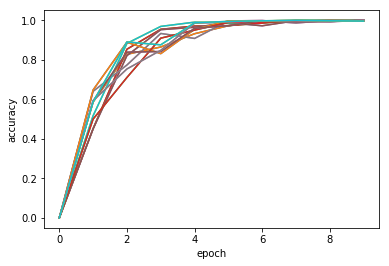

In [9]:
myscheduler.join_tasks()
myscheduler.get_training_curves(plot=True, use_legend=False)